# Character Sequence to Sequence 

In [1]:
import helpers
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
source_path = '../data/letters_source.txt'
target_path = '../data/letters_target.txt'

source_sentences = helpers.load_data(source_path)
target_sentences = helpers.load_data(target_path)

In [3]:
source_sentences[:50].split('\n')

['bsaqq',
 'npy',
 'lbwuj',
 'bqv',
 'kial',
 'tddam',
 'edxpjpg',
 'nspv',
 'huloz',
 '']

In [4]:
target_sentences[:50].split('\n')

['abqqs',
 'npy',
 'bjluw',
 'bqv',
 'aikl',
 'addmt',
 'degjppx',
 'npsv',
 'hlouz',
 '']

In [5]:
def extract_character_vocab(data):
    special_characters = ['<PAD>', '<UNK>', '<GO>',  '<EOS>']
    # <PAD>:补全字符
    # <EOS>:解码器端的句子结束标识符
    # <UNK>:低频词或者一些未遇到的词等
    # <GO>:解码器端的句子起始标识符
    
    set_characters = set([character for line in data.split('\n') for character in line])
    int_to_vocab = {i:character for i,character in enumerate(special_characters+list(set_characters))}
    vocab_to_int = {character:i for i,character in int_to_vocab.items()}
    return int_to_vocab, vocab_to_int

source_int_to_letter, source_letter_to_int = extract_character_vocab(source_sentences)
target_int_to_letter, target_letter_to_int = extract_character_vocab(target_sentences)

source_letter_ids = [[source_letter_to_int.get(letter, source_letter_to_int['<UNK>']) for letter in line]
                     for line in source_sentences.split('\n')]
target_letter_ids = [[target_letter_to_int.get(letter, target_letter_to_int['<UNK>']) for letter in line]+ [target_letter_to_int['<EOS>']]
                     for line in target_sentences.split('\n')]

print("Example source sequence")
print(source_letter_ids[:3])
print("\n")
print("Example target sequence")
print(target_letter_ids[:3])

Example source sequence
[[28, 25, 7, 13, 13], [27, 12, 17], [19, 28, 9, 26, 10]]


Example target sequence
[[7, 28, 13, 13, 25, 3], [27, 12, 17, 3], [28, 10, 19, 26, 9, 3]]


In [6]:
import pickle
with open("letter_dicts.pkl",'wb') as f:
    pickle.dump([source_int_to_letter, source_letter_to_int,target_int_to_letter, target_letter_to_int],f)

In [7]:
# Hyperparameters

# Number of Epochs
epochs = 60
# Batch Size
batch_size = 128
# RNN Size
rnn_size = 50
# Number of Layers
num_layers = 2
# Embedding Size
encoder_embedding_size = 15
decoder_embedding_size = 15
# Learning Rate
learning_rate = 0.001

In [8]:
# Input
tf.reset_default_graph()
inputs_ = tf.placeholder(shape=[None, None],dtype=tf.int32, name="inputs")
targets_ = tf.placeholder(shape=[None, None], dtype=tf.int32, name="targets")
lr = tf.placeholder(dtype=tf.float32, name="learning_rate")
target_sequence_lengths = tf.placeholder(shape=[None],dtype=tf.int32, name="target_sequence_lengths")
max_target_sequence_length = tf.reduce_max(target_sequence_lengths, name='max_target_sequence_length')
source_sequence_lengths = tf.placeholder(shape=[None],dtype=tf.int32, name="source_sequence_lengths")

In [9]:
# Encoder
def encoder_layer(inputs, rnn_size, num_layers, source_sequence_length, 
            source_vocab_size,encoder_embedding_size):
    encoder_input_embed = tf.contrib.layers.embed_sequence(inputs, source_vocab_size, encoder_embedding_size)
    def make_cell(rnn_size):
        lstm = tf.contrib.rnn.LSTMCell(rnn_size)
        return lstm
    encoder_cell = tf.contrib.rnn.MultiRNNCell([make_cell(rnn_size) for _ in range(num_layers)])
    encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
        encoder_cell, encoder_input_embed, sequence_length=source_sequence_length, dtype=tf.float32, scope="encoder_rnn")
    return encoder_outputs, encoder_final_state

In [10]:
def process_decoder_input(target_data, vocab_to_int, batch_size):
    '''Remove the last word id from each batch and concat the <GO> to the begining of each batch'''
    slices = tf.strided_slice(target_data, [0,0],[batch_size,-1],[1,1])
    decoder_inputs = tf.concat([tf.fill([batch_size,1], vocab_to_int['<GO>']), slices],1)
    return decoder_inputs

In [11]:
# Decoder
def decoder_layer(decoder_inputs, targets, encoder_state, rnn_size, num_layers, 
            target_sequence_length, max_target_sequence_length, 
            target_letter_to_int, decoder_embedding_size):
    # Decoder Embdding
    target_vocab_size= len(target_letter_to_int)
    decoder_embedding = tf.Variable(tf.random_uniform([target_vocab_size, decoder_embedding_size], -1.0, 1.0))
    decoder_input_embed = tf.nn.embedding_lookup(decoder_embedding, decoder_inputs)
    
    # Decoder cell
    def make_cell(rnn_size):
        lstm = tf.contrib.rnn.LSTMCell(rnn_size)
        return lstm
    decoder_cell = tf.contrib.rnn.MultiRNNCell([make_cell(rnn_size) for _ in range(num_layers)])
    
    # Ouput 
    ouput_layer = tf.contrib.keras.layers.Dense(
        target_vocab_size, kernel_initializer=tf.truncated_normal_initializer(mean = 0.0, stddev=0.1))
    
    # Training Decoder
    with tf.variable_scope("decoder"):
        # Using TrainingHelper to read inputs
        train_helper = tf.contrib.seq2seq.TrainingHelper(
            decoder_input_embed, target_sequence_lengths)
        
        train_decoder = tf.contrib.seq2seq.BasicDecoder(
            decoder_cell, train_helper, encoder_state, ouput_layer)
        
        train_decoder_outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(
            train_decoder, maximum_iterations=max_target_sequence_length, impute_finished=True)
    
    # Inference
    with tf.variable_scope("decoder", reuse=True):
        start_tokens = tf.fill([batch_size],target_letter_to_int['<GO>'])
        infer_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
            embedding=decoder_embedding, start_tokens=start_tokens, end_token=target_letter_to_int['<EOS>'])
        
        infer_decoder = tf.contrib.seq2seq.BasicDecoder(
            decoder_cell, infer_helper, encoder_state, ouput_layer)
        
        infer_decoder_outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(
            infer_decoder, maximum_iterations=max_target_sequence_length, impute_finished=True)
    
    return train_decoder_outputs, infer_decoder_outputs

In [12]:
_, encoder_final_state = encoder_layer(inputs_, rnn_size, num_layers, source_sequence_lengths, 
                                       len(source_letter_to_int),encoder_embedding_size)

decoder_inputs = process_decoder_input(targets_, target_letter_to_int, batch_size)

train_decoder_outputs, infer_decoder_outputs = decoder_layer(decoder_inputs, targets_, encoder_final_state, rnn_size, num_layers,
                                                             target_sequence_lengths, max_target_sequence_length, target_letter_to_int, decoder_embedding_size)

train_logits = tf.identity(train_decoder_outputs.rnn_output, 'logits')
infere_logits = tf.identity(infer_decoder_outputs.sample_id, name='predictions')

masks = tf.sequence_mask(target_sequence_lengths, max_target_sequence_length, dtype=tf.float32, name='masks')

with tf.name_scope("optimization"):
    cost = tf.contrib.seq2seq.sequence_loss(logits=train_logits, targets = targets_, weights = masks)
    optimizer = tf.train.AdamOptimizer(lr)
    gradients = optimizer.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in gradients if grad is not None]
    train_op = optimizer.apply_gradients(capped_gradients)

In [13]:
masks

<tf.Tensor 'masks/Cast_1:0' shape=(?, ?) dtype=float32>

<img src="../data/source_batch.png" />

<img src="../data/target_batch.png" />

In [14]:
def pad_sentence_batch(sentence_batch, pad_int):
    """Pad sentences with <PAD> so that each sentence of a batch has the same length"""
    max_sentence_length = max([len(sentence) for sentence in sentence_batch])
    return [sentence + [pad_int]*(max_sentence_length-len(sentence)) for sentence in sentence_batch]

In [15]:
def get_batches(targets, sources, batch_size, source_pad_int, target_pad_int):
    for batch_i in range(0, len(sources)//batch_size):
        sources_batch = sources[batch_i * batch_size:(batch_i+1) * batch_size]
        targets_batch = targets[batch_i * batch_size:(batch_i+1) * batch_size]
        pad_sources_batch = np.array(pad_sentence_batch(sources_batch, source_pad_int))
        pad_targets_batch = np.array(pad_sentence_batch(targets_batch, target_pad_int))
        
        pad_targets_lengths = []
        for target in pad_targets_batch:
            pad_targets_lengths.append(len(target))
        
        pad_source_lengths = []
        for source in pad_sources_batch:
            pad_source_lengths.append(len(source))
        
        yield pad_targets_batch, pad_sources_batch, pad_targets_lengths, pad_source_lengths      

In [16]:
train_source = source_letter_ids[batch_size:]
train_target = target_letter_ids[batch_size:]
valid_source = source_letter_ids[:batch_size]
valid_target = target_letter_ids[:batch_size]
(valid_targets_batch, valid_sources_batch, valid_targets_lengths, valid_sources_lengths) = next(get_batches(valid_target, valid_source, batch_size,
                           source_letter_to_int['<PAD>'],
                           target_letter_to_int['<PAD>']))

display_step = 20 # Check training loss after every 20 batches

checkpoint = "../data/letter_checkpoints/best_model.ckpt" 
loss_track=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch_i in range(1,epochs+1):
        for batch_i, (targets_batch, sources_batch, targets_lengths, sources_lengths) in enumerate(
                get_batches(train_target, train_source, batch_size,
                           source_letter_to_int['<PAD>'],
                           target_letter_to_int['<PAD>'])):
            _, loss = sess.run([train_op,cost],feed_dict={
                    inputs_:sources_batch,
                    targets_:targets_batch,
                    lr:learning_rate,
                    target_sequence_lengths:targets_lengths,
                    source_sequence_lengths:sources_lengths
                })
            loss_track.append(loss)
            if batch_i % display_step == 0 and batch_i > 0:
                val_loss = sess.run([cost], feed_dict={
                        inputs_:valid_sources_batch,
                        targets_:valid_targets_batch,
                        source_sequence_lengths:valid_sources_lengths,
                        target_sequence_lengths:valid_targets_lengths
                    })
                print('Epoch {:>3}/{} Batch {:>4}/{} - Loss: {:>6.3f}  - Validation loss: {:>6.3f}'
                      .format(epoch_i,
                              epochs, 
                              batch_i, 
                              len(train_source) // batch_size, 
                              loss, 
                              val_loss[0]))
    
    saver = tf.train.Saver()
    saver.save(sess, checkpoint)
    print('Model Trained and Saved')          

Epoch   1/60 Batch   20/77 - Loss:  2.401  - Validation loss:  2.428
Epoch   1/60 Batch   40/77 - Loss:  2.192  - Validation loss:  2.145
Epoch   1/60 Batch   60/77 - Loss:  1.942  - Validation loss:  1.989
Epoch   2/60 Batch   20/77 - Loss:  1.687  - Validation loss:  1.765
Epoch   2/60 Batch   40/77 - Loss:  1.692  - Validation loss:  1.652
Epoch   2/60 Batch   60/77 - Loss:  1.528  - Validation loss:  1.554
Epoch   3/60 Batch   20/77 - Loss:  1.384  - Validation loss:  1.455
Epoch   3/60 Batch   40/77 - Loss:  1.460  - Validation loss:  1.429
Epoch   3/60 Batch   60/77 - Loss:  1.374  - Validation loss:  1.398
Epoch   4/60 Batch   20/77 - Loss:  1.273  - Validation loss:  1.342
Epoch   4/60 Batch   40/77 - Loss:  1.331  - Validation loss:  1.287
Epoch   4/60 Batch   60/77 - Loss:  1.202  - Validation loss:  1.240
Epoch   5/60 Batch   20/77 - Loss:  1.093  - Validation loss:  1.164
Epoch   5/60 Batch   40/77 - Loss:  1.148  - Validation loss:  1.128
Epoch   5/60 Batch   60/77 - Loss:

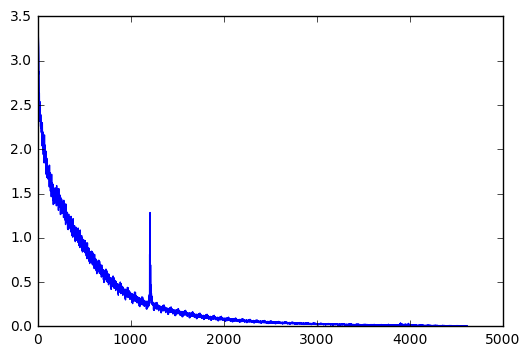

In [17]:
plt.plot(loss_track)

In [1]:
import tensorflow as tf
import numpy as np
import pickle
with open("letter_dicts.pkl",'rb') as f:
    source_int_to_letter, source_letter_to_int,target_int_to_letter, target_letter_to_int =pickle.load(f)

In [2]:
def source_to_seq(text,sequence_length = 7):
    return [source_letter_to_int.get(word, source_letter_to_int['<UNK>']) for word in text]+ [source_letter_to_int['<PAD>']]*(sequence_length-len(text))

In [3]:
input_sentence = 'hello'
text = source_to_seq(input_sentence)
batch_size=128
checkpoint = "../data/letter_checkpoints/best_model.ckpt" 
loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    loader = tf.train.import_meta_graph(checkpoint+'.meta')
    loader.restore(sess, checkpoint)
    inputs = loaded_graph.get_tensor_by_name('inputs:0')
    preds = loaded_graph.get_tensor_by_name("predictions:0")
    source_sequence_lengths = loaded_graph.get_tensor_by_name('source_sequence_lengths:0')
    target_sequence_lengths = loaded_graph.get_tensor_by_name('target_sequence_lengths:0')
    
    #Multiply by batch_size to match the model's input parameters
    answers = sess.run(preds, feed_dict={
            inputs: [text]*batch_size,
            source_sequence_lengths: [len(text)]*batch_size,
            target_sequence_lengths: [len(text)]*batch_size
        })

INFO:tensorflow:Restoring parameters from ../data/letter_checkpoints/best_model.ckpt


In [4]:
print(answers.shape)
print(len(text))

(128, 6)
7


In [5]:
pad = source_letter_to_int["<PAD>"] 
print('Original Text:', input_sentence)

print('\nSource')
print('  Word Ids:    {}'.format(text))
print('  Input Words: {}'.format(" ".join([source_int_to_letter[i] for i in text])))

print('\nTarget')
print('  Word Ids:       {}'.format(answers[0]))
print('  Response Words: {}'.format(" ".join([target_int_to_letter[i] for i in answers[0] if i != pad])))

Original Text: hello

Source
  Word Ids:    [18, 4, 19, 19, 24, 0, 0]
  Input Words: h e l l o <PAD> <PAD>

Target
  Word Ids:       [ 4 18 19 19 24  3]
  Response Words: e h l l o <EOS>
